In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# Load and preprocess data 
# Load the data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Encode categorical variables
le_gen = LabelEncoder()
le_primary = LabelEncoder()
le_secondary = LabelEncoder()

train_df['Generation'] = le_gen.fit_transform(train_df['Generation'])
train_df['Primary_Type'] = le_primary.fit_transform(train_df['Primary_Type'])
train_df['Secondary_Type'] = le_secondary.fit_transform(train_df['Secondary_Type'].fillna('None'))

test_df['Generation'] = le_gen.transform(test_df['Generation'])
test_df['Primary_Type'] = le_primary.transform(test_df['Primary_Type'])
test_df['Secondary_Type'] = le_secondary.transform(test_df['Secondary_Type'].fillna('None'))

# Convert to one-hot encoding
gen_classes = len(le_gen.classes_)
primary_classes = len(le_primary.classes_)
secondary_classes = len(le_secondary.classes_)

y_train_gen = to_categorical(train_df['Generation'], num_classes=gen_classes)
y_train_primary = to_categorical(train_df['Primary_Type'], num_classes=primary_classes)
y_train_secondary = to_categorical(train_df['Secondary_Type'], num_classes=secondary_classes)

y_test_gen = to_categorical(test_df['Generation'], num_classes=gen_classes)
y_test_primary = to_categorical(test_df['Primary_Type'], num_classes=primary_classes)
y_test_secondary = to_categorical(test_df['Secondary_Type'], num_classes=secondary_classes)

In [3]:
import os
from PIL import Image
import numpy as np

def load_and_preprocess_image(row, base_dir='pokemon_train_images', target_size=(224, 224)):
    name = row['Name']
    gen = int(row['Generation'])
    
    # Construct the path to the image
    # note the image paths
    img_path = os.path.join(base_dir, f'gen_{gen+1}.0', f'{name}.png')
    
    try:
        # Open the image
        img = Image.open(img_path).convert('RGBA')
        
        # Create a white background
        background = Image.new('RGBA', img.size, (255, 255, 255, 255))
        
        # Alpha composite the image with the background
        img = Image.alpha_composite(background, img)
        
        # Make white background transparent
        data = np.array(img)
        r, g, b, a = data.T
        white_areas = (r == 255) & (g == 255) & (b == 255)
        data[..., :][white_areas.T] = (255, 255, 255, 0)
        
        # Convert back to PIL Image and resize
        img = Image.fromarray(data)
        img = img.resize(target_size)
        
        # Convert to RGB (removing alpha channel) and normalize
        img_array = np.array(img.convert('RGB')) / 255.0
        
        return img_array
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")
        return None

# Apply the function to your DataFrame and handle None values
X_train = []
for _, row in train_df.iterrows():
    img = load_and_preprocess_image(row)
    if img is not None:
        X_train.append(img)

X_test = []
for _, row in test_df.iterrows():
    img = load_and_preprocess_image(row, base_dir='pokemon_test_images')
    if img is not None:
        X_test.append(img)

# Convert to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (820, 224, 224, 3)
X_test shape: (205, 224, 224, 3)


In [4]:
# Model architecture

# Get paths from manually downlaoded weights
weights_path = '.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model = ResNet50(weights=weights_path, include_top=False, input_shape=(224, 224, 3))

x = GlobalAveragePooling2D()(base_model.output)

# Generation branch
gen_output = Dense(gen_classes, activation='softmax', name='generation')(x)

# Primary Type branch
primary_output = Dense(primary_classes, activation='softmax', name='primary_type')(x)

# Secondary Type branch
secondary_output = Dense(secondary_classes, activation='softmax', name='secondary_type')(x)

model = Model(inputs=base_model.input, outputs=[gen_output, primary_output, secondary_output])

In [5]:
# Model compilation
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'generation': 'categorical_crossentropy',
                    'primary_type': 'categorical_crossentropy',
                    'secondary_type': 'categorical_crossentropy'},
              metrics={'generation': 'accuracy',
                       'primary_type': 'accuracy',
                       'secondary_type': 'accuracy'})

history = model.fit(X_train, 
                    {'generation': y_train_gen, 
                     'primary_type': y_train_primary, 
                     'secondary_type': y_train_secondary},
                    validation_split=0.2,
                    epochs=5,
                    batch_size=16)

Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - generation_accuracy: 0.2126 - generation_loss: 2.2863 - loss: 7.7659 - primary_type_accuracy: 0.1352 - primary_type_loss: 2.9801 - secondary_type_accuracy: 0.4163 - secondary_type_loss: 2.4995 - val_generation_accuracy: 0.1220 - val_generation_loss: 10183.1738 - val_loss: 28647.6523 - val_primary_type_accuracy: 0.0732 - val_primary_type_loss: 8772.6318 - val_secondary_type_accuracy: 0.0305 - val_secondary_type_loss: 9391.5850
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - generation_accuracy: 0.3305 - generation_loss: 1.8219 - loss: 6.4222 - primary_type_accuracy: 0.2251 - primary_type_loss: 2.4777 - secondary_type_accuracy: 0.4562 - secondary_type_loss: 2.1226 - val_generation_accuracy: 0.0976 - val_generation_loss: 3.4246 - val_loss: 8.9798 - val_primary_type_accuracy: 0.0671 - val_primary_type_loss: 3.0856 - val_secondary_type_accuracy: 0.4634 - val_secondary_type_loss: 2.4914
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - g

In [7]:
# Data augmentation and model training

# print("X_train shape:", X_train.shape)
# print("y_train_gen shape:", y_train_gen.shape)
# print("y_train_primary shape:", y_train_primary.shape)
# print("y_train_secondary shape:", y_train_secondary.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Combine target variables
y_train = [y_train_gen, y_train_primary, y_train_secondary]
y_test = [y_test_gen, y_test_primary, y_test_secondary]

# Further training with data augmentation
augmented_history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_test, y_test)
)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 820) + inhomogeneous part.

In [8]:
# Model evaluation
test_loss, test_gen_loss, test_primary_loss, test_secondary_loss, test_gen_acc, test_primary_acc, test_secondary_acc = model.evaluate(X_test, [y_test_gen, y_test_primary, y_test_secondary])

print(f"Test Generation Accuracy: {test_gen_acc:.4f}")
print(f"Test Primary Type Accuracy: {test_primary_acc:.4f}")
print(f"Test Secondary Type Accuracy: {test_secondary_acc:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 668ms/step - generation_accuracy: 0.1529 - generation_loss: 4.5043 - loss: 10.5637 - primary_type_accuracy: 0.0348 - primary_type_loss: 3.2398 - secondary_type_accuracy: 0.0095 - secondary_type_loss: 2.8308
Test Generation Accuracy: 0.1366
Test Primary Type Accuracy: 0.0293
Test Secondary Type Accuracy: 0.0098


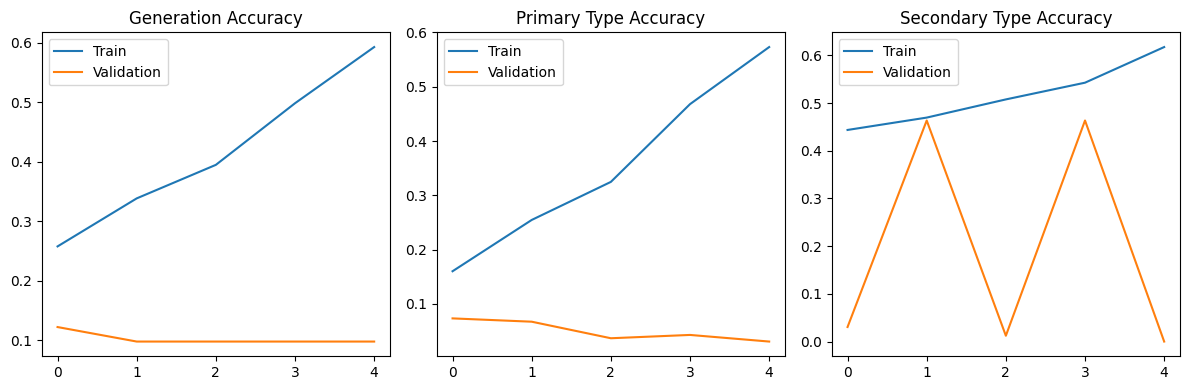

In [9]:
# Visualize training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['generation_accuracy'], label='Train')
plt.plot(history.history['val_generation_accuracy'], label='Validation')
plt.title('Generation Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['primary_type_accuracy'], label='Train')
plt.plot(history.history['val_primary_type_accuracy'], label='Validation')
plt.title('Primary Type Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['secondary_type_accuracy'], label='Train')
plt.plot(history.history['val_secondary_type_accuracy'], label='Validation')
plt.title('Secondary Type Accuracy')
plt.legend()

plt.tight_layout()
plt.show()